In [1]:
#Imports
import numpy as np
import pandas as pd
import talib as ta
import seaborn as sns
import matplotlib.pyplot as plt

# Read Data

In [2]:
path = "C:\\Users\\rohit\\OneDrive\\Udacity ML\\machine-learning-master\\projects\\capstone\\Stock Time Series Analysis\\"
data = pd.read_csv(path+'INFY.NS.csv',index_col=[0],parse_dates=True,dayfirst=False)

In [3]:
#Remove NA's
data.dropna(inplace=True)
print (data.tail())

              Open         High          Low        Close    Adj Close  \
Date                                                                     
2018-04-23  1168.0  1214.400024  1155.250000  1187.699951  1187.699951   
2018-04-24  1185.0  1196.400024  1150.099976  1154.500000  1154.500000   
2018-04-25  1152.0  1171.000000  1145.199951  1160.349976  1160.349976   
2018-04-26  1174.0  1181.650024  1160.000000  1176.449951  1176.449951   
2018-04-27  1180.0  1191.599976  1174.199951  1185.199951  1185.199951   

                Volume  
Date                    
2018-04-23  10915319.0  
2018-04-24   4263108.0  
2018-04-25   5797089.0  
2018-04-26   5651042.0  
2018-04-27   3831685.0  


# Features

In [4]:
#Filter only relevant columns
df = data[['Open','High','Low','Close']]

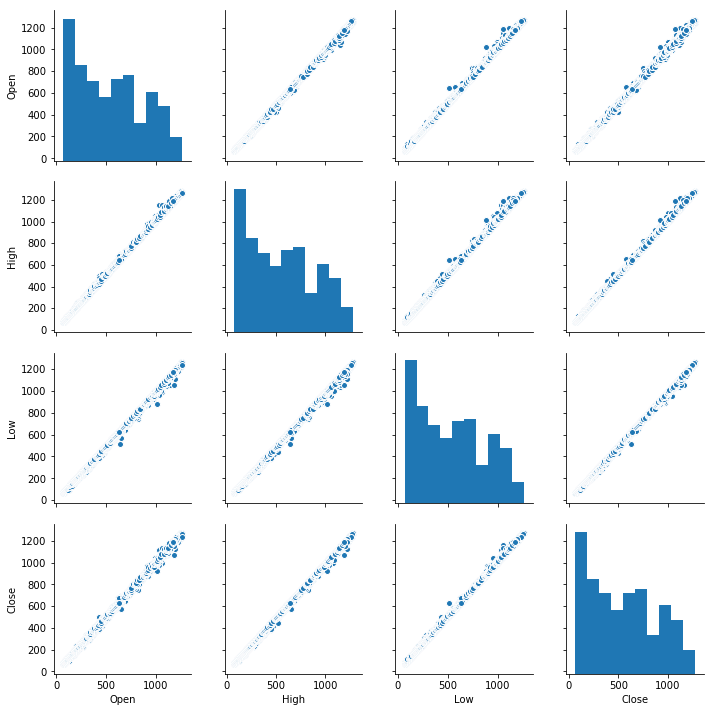

In [5]:
#Check correlation between columns
%matplotlib inline
g = sns.pairplot(df)

# Introduce New Features (Technical Indicators)

In [6]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['RSI'] = ta.RSI(np.array(df['Close']),timeperiod=10)
df['ADX'] = ta.ADX(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=7)
df['SAR'] = ta.SAR(np.array(df['High']),np.array(df['Low']),0.2,0.2)
df['Williams-R'] = ta.WILLR(df['High'].values, df['Low'].values, df['Close'].values, 7)

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
df.dropna(inplace=True)
df_filtered = df[['H-L','O-C','RSI','ADX','SAR','Williams-R']]

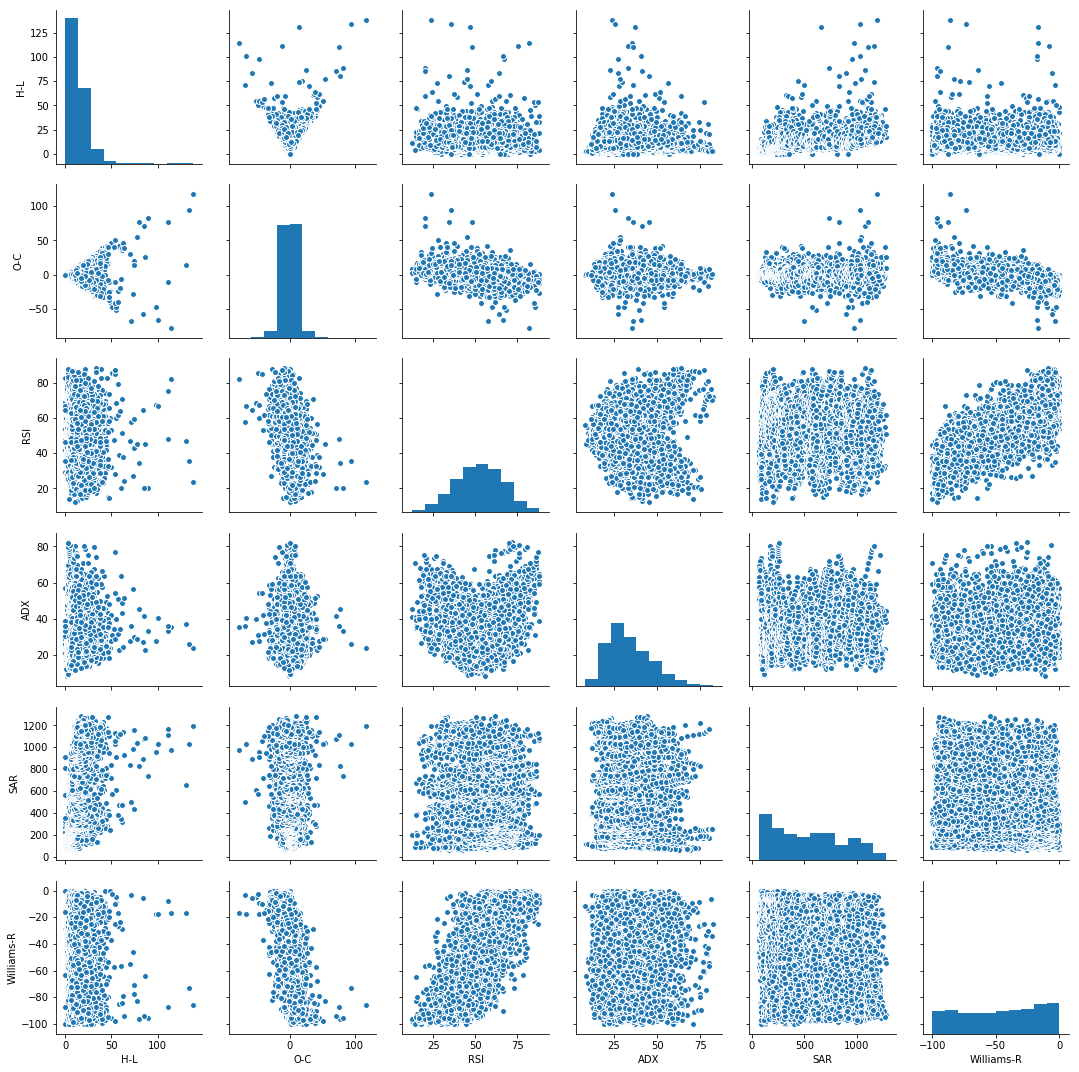

In [8]:
%matplotlib inline
g = sns.pairplot(df_filtered)

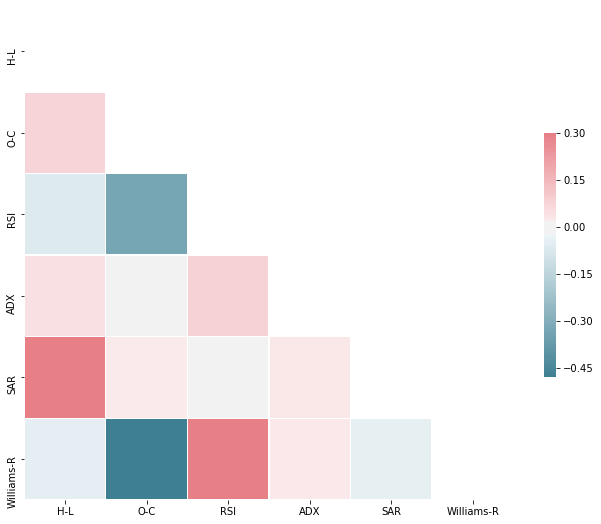

In [9]:
#Generate Correlation Matrix
corr = df_filtered.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Introduce Independent Variable

In [10]:
#Compare next day price with todays price
#If next days price greater than today then Price_change is 1 else 0
df['Price_Change'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [11]:
features = ['H-L','O-C','RSI','ADX','SAR','Williams-R']

X = df[features]
y = df['Price_Change']

# Perform Test Train Split

In [12]:
s = 0.03

split = int((1-s)*len(X))

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4387 samples.
Testing set has 136 samples.


# Normalizing Features

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Neural Network

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [15]:
from sklearn import metrics

In [16]:
def equity_vol(rtn_series):
    '''
    daily return series
    '''
    
    vol = np.std(rtn_series)*np.sqrt(252)
    
    return vol

def equity_return(rtn_series):
    '''
    daily return series
    '''
    rtn_series.fillna(0, inplace=True)    
    
    equity_line = 100*(1+np.cumsum(rtn_series))
    
    equity_line_rtn = (equity_line.ix[-1]/100)**(252.0/(len(rtn_series)-1)) -1
    
    return equity_line_rtn

In [17]:
def cross_validation(X,y,s=0.2):
    
    split = int((1-s)*len(X))

    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Show the results of the split
    print ("Training set has {} samples.".format(X_train.shape[0]))
    print ("Testing set has {} samples.".format(X_test.shape[0]))
    
    classifier = Sequential()
    classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
    classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)
    
    #Predictions
    y_pred = classifier.predict(X_test)
    #Differenciate between up markets and down markets predictions
    y_pred = (y_pred > 0.5)
    
    #Create dataframe to predict out of sample data
    df['y_pred'] = np.NaN
    df.iloc[(len(df) - len(y_pred)):,-1:] = y_pred
    long_short_strategy = df.dropna()

    #Get Next Day Returns
    long_short_strategy['Tomorrows Returns'] = 0.
    long_short_strategy['Tomorrows Returns'] = np.log(long_short_strategy['Close']/long_short_strategy['Close'].shift(1))
    long_short_strategy['Tomorrows Returns'] = long_short_strategy['Tomorrows Returns'].shift(-1)

    #If Signal is True, go Long else go Short
    long_short_strategy['Strategy Returns'] = 0.
    long_short_strategy['Strategy Returns'] = np.where(long_short_strategy['y_pred'] == True, long_short_strategy['Tomorrows Returns'],
                                             - long_short_strategy['Tomorrows Returns'])
    #Generate cumulative returns
    long_short_strategy['Cumulative Market Returns'] = np.cumsum(long_short_strategy['Tomorrows Returns'])
    long_short_strategy['Cumulative Strategy Returns'] = np.cumsum(long_short_strategy['Strategy Returns'])
    
    accuracy = metrics.accuracy_score(y_test,y_pred)
    
    returns = (equity_return(long_short_strategy['Strategy Returns']))
    vol = (equity_vol(long_short_strategy['Strategy Returns']))
    
    market_returns = (equity_return(long_short_strategy['Tomorrows Returns']))
    market_vol = (equity_vol(long_short_strategy['Tomorrows Returns']))
                  
    excess_return = returns - market_returns

    return accuracy,returns,vol,market_returns,market_vol,excess_return

In [18]:
split_sizes = [0.2,0.18,0.16,0.14,0.12,0.10,0.08,0.06,0.04,0.03,0.02,0.01]

cv_results = {}

for  ss in split_sizes:
    cv_results[ss] = cross_validation(X,y,s=ss)

Training set has 3618 samples.
Testing set has 905 samples.
Epoch 1/100
3618/3618 [==============================] - 3s 747us/step - loss: 0.2501 - acc: 0.5055
Epoch 2/100
3618/3618 [==============================] - 1s 413us/step - loss: 0.2496 - acc: 0.5207
Epoch 3/100
3618/3618 [==============================] - 1s 355us/step - loss: 0.2494 - acc: 0.5202
Epoch 4/100
3618/3618 [==============================] - 2s 425us/step - loss: 0.2489 - acc: 0.5268
Epoch 5/100
3618/3618 [==============================] - 1s 400us/step - loss: 0.2491 - acc: 0.5257
Epoch 6/100
3618/3618 [==============================] - 2s 516us/step - loss: 0.2485 - acc: 0.5301
Epoch 7/100
3618/3618 [==============================] - 1s 388us/step - loss: 0.2483 - acc: 0.5304
Epoch 8/100
3618/3618 [==============================] - 1s 353us/step - loss: 0.2480 - acc: 0.5381
Epoch 9/100
3618/3618 [==============================] - 1s 375us/step - loss: 0.2478 - acc: 0.5387 1s - lo
Epoch 10/100
3618/3618 [========

3618/3618 [==============================] - 1s 172us/step - loss: 0.2104 - acc: 0.6716
Epoch 82/100
3618/3618 [==============================] - 1s 168us/step - loss: 0.2090 - acc: 0.6680
Epoch 83/100
3618/3618 [==============================] - 1s 173us/step - loss: 0.2083 - acc: 0.6703
Epoch 84/100
3618/3618 [==============================] - 1s 167us/step - loss: 0.2079 - acc: 0.6722
Epoch 85/100
3618/3618 [==============================] - 1s 169us/step - loss: 0.2061 - acc: 0.6772
Epoch 86/100
3618/3618 [==============================] - 1s 296us/step - loss: 0.2066 - acc: 0.6719
Epoch 87/100
3618/3618 [==============================] - 1s 408us/step - loss: 0.2040 - acc: 0.6819
Epoch 88/100
3618/3618 [==============================] - 2s 482us/step - loss: 0.2038 - acc: 0.6855
Epoch 89/100
3618/3618 [==============================] - 1s 407us/step - loss: 0.2033 - acc: 0.6744
Epoch 90/100
3618/3618 [==============================] - 1s 326us/step - loss: 0.2022 - acc: 0.6882
Epo

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

Training set has 3708 samples.
Testing set has 815 samples.
Epoch 1/100
3708/3708 [==============================] - 3s 716us/step - loss: 0.2500 - acc: 0.5027
Epoch 2/100
3708/3708 [==============================] - 2s 425us/step - loss: 0.2496 - acc: 0.5218
Epoch 3/100
3708/3708 [==============================] - 1s 402us/step - loss: 0.2495 - acc: 0.5186
Epoch 4/100
3708/3708 [==============================] - 1s 391us/step - loss: 0.2489 - acc: 0.5345
Epoch 5/100
3708/3708 [==============================] - 1s 388us/step - loss: 0.2486 - acc: 0.5237
Epoch 6/100
3708/3708 [==============================] - 2s 444us/step - loss: 0.2485 - acc: 0.5353
Epoch 7/100
3708/3708 [==============================] - 2s 443us/step - loss: 0.2483 - acc: 0.5372
Epoch 8/100
3708/3708 [==============================] - 2s 446us/step - loss: 0.2479 - acc: 0.5359
Epoch 9/100
3708/3708 [==============================] - 2s 426us/step - loss: 0.2476 - acc: 0.5361
Epoch 10/100
3708/3708 [================

3708/3708 [==============================] - 1s 258us/step - loss: 0.2117 - acc: 0.6626
Epoch 82/100
3708/3708 [==============================] - 1s 392us/step - loss: 0.2111 - acc: 0.6621
Epoch 83/100
3708/3708 [==============================] - 1s 389us/step - loss: 0.2102 - acc: 0.6675
Epoch 84/100
3708/3708 [==============================] - 2s 418us/step - loss: 0.2095 - acc: 0.6661
Epoch 85/100
3708/3708 [==============================] - 1s 395us/step - loss: 0.2090 - acc: 0.6680
Epoch 86/100
3708/3708 [==============================] - 1s 394us/step - loss: 0.2075 - acc: 0.6699
Epoch 87/100
3708/3708 [==============================] - 1s 397us/step - loss: 0.2073 - acc: 0.6699
Epoch 88/100
3708/3708 [==============================] - 1s 403us/step - loss: 0.2061 - acc: 0.6780
Epoch 89/100
3708/3708 [==============================] - 1s 402us/step - loss: 0.2049 - acc: 0.6872
Epoch 90/100
3708/3708 [==============================] - 2s 408us/step - loss: 0.2058 - acc: 0.6769
Epo

3799/3799 [==============================] - 1s 251us/step - loss: 0.2251 - acc: 0.6241
Epoch 62/100
3799/3799 [==============================] - 1s 312us/step - loss: 0.2243 - acc: 0.6270
Epoch 63/100
3799/3799 [==============================] - 1s 313us/step - loss: 0.2243 - acc: 0.6233
Epoch 64/100
3799/3799 [==============================] - 1s 312us/step - loss: 0.2227 - acc: 0.6307
Epoch 65/100
3799/3799 [==============================] - 1s 334us/step - loss: 0.2220 - acc: 0.6310
Epoch 66/100
3799/3799 [==============================] - 1s 317us/step - loss: 0.2223 - acc: 0.6402
Epoch 67/100
3799/3799 [==============================] - 1s 324us/step - loss: 0.2212 - acc: 0.6357
Epoch 68/100
3799/3799 [==============================] - 1s 342us/step - loss: 0.2206 - acc: 0.6362
Epoch 69/100
3799/3799 [==============================] - 1s 311us/step - loss: 0.2197 - acc: 0.6346
Epoch 70/100
3799/3799 [==============================] - 1s 281us/step - loss: 0.2184 - acc: 0.6410
Epo

3889/3889 [==============================] - 1s 177us/step - loss: 0.2408 - acc: 0.5742
Epoch 42/100
3889/3889 [==============================] - 1s 175us/step - loss: 0.2396 - acc: 0.5847
Epoch 43/100
3889/3889 [==============================] - 1s 286us/step - loss: 0.2394 - acc: 0.5788
Epoch 44/100
3889/3889 [==============================] - 2s 487us/step - loss: 0.2395 - acc: 0.5719
Epoch 45/100
3889/3889 [==============================] - 1s 344us/step - loss: 0.2385 - acc: 0.5840
Epoch 46/100
3889/3889 [==============================] - 1s 273us/step - loss: 0.2387 - acc: 0.5798
Epoch 47/100
3889/3889 [==============================] - 1s 273us/step - loss: 0.2375 - acc: 0.5842
Epoch 48/100
3889/3889 [==============================] - 1s 269us/step - loss: 0.2378 - acc: 0.5840
Epoch 49/100
3889/3889 [==============================] - 1s 272us/step - loss: 0.2374 - acc: 0.5904
Epoch 50/100
3889/3889 [==============================] - 1s 273us/step - loss: 0.2359 - acc: 0.5917
Epo

3980/3980 [==============================] - 1s 276us/step - loss: 0.2458 - acc: 0.5508
Epoch 22/100
3980/3980 [==============================] - 1s 279us/step - loss: 0.2450 - acc: 0.5573
Epoch 23/100
3980/3980 [==============================] - 1s 270us/step - loss: 0.2451 - acc: 0.5535
Epoch 24/100
3980/3980 [==============================] - 2s 406us/step - loss: 0.2446 - acc: 0.5553
Epoch 25/100
3980/3980 [==============================] - 2s 414us/step - loss: 0.2443 - acc: 0.5580
Epoch 26/100
3980/3980 [==============================] - 2s 408us/step - loss: 0.2444 - acc: 0.5606
Epoch 27/100
3980/3980 [==============================] - 2s 479us/step - loss: 0.2435 - acc: 0.5636
Epoch 28/100
3980/3980 [==============================] - 1s 353us/step - loss: 0.2430 - acc: 0.5611
Epoch 29/100
3980/3980 [==============================] - 1s 313us/step - loss: 0.2431 - acc: 0.5643
Epoch 30/100
3980/3980 [==============================] - 1s 319us/step - loss: 0.2422 - acc: 0.5646
Epo

Epoch 1/100
4070/4070 [==============================] - 3s 780us/step - loss: 0.2501 - acc: 0.5098
Epoch 2/100
4070/4070 [==============================] - 2s 546us/step - loss: 0.2499 - acc: 0.5199
Epoch 3/100
4070/4070 [==============================] - ETA: 0s - loss: 0.2493 - acc: 0.527 - 2s 432us/step - loss: 0.2494 - acc: 0.5270
Epoch 4/100
4070/4070 [==============================] - 2s 456us/step - loss: 0.2491 - acc: 0.5256
Epoch 5/100
4070/4070 [==============================] - 2s 413us/step - loss: 0.2487 - acc: 0.5280
Epoch 6/100
4070/4070 [==============================] - 2s 448us/step - loss: 0.2490 - acc: 0.5229
Epoch 7/100
4070/4070 [==============================] - 1s 337us/step - loss: 0.2486 - acc: 0.5258
Epoch 8/100
4070/4070 [==============================] - 1s 279us/step - loss: 0.2484 - acc: 0.5275
Epoch 9/100
4070/4070 [==============================] - 1s 282us/step - loss: 0.2483 - acc: 0.5337
Epoch 10/100
4070/4070 [==============================] - 1s 2

Epoch 81/100
4070/4070 [==============================] - 1s 317us/step - loss: 0.2162 - acc: 0.6506
Epoch 82/100
4070/4070 [==============================] - 2s 416us/step - loss: 0.2165 - acc: 0.6469
Epoch 83/100
4070/4070 [==============================] - 2s 471us/step - loss: 0.2145 - acc: 0.6595
Epoch 84/100
4070/4070 [==============================] - 2s 468us/step - loss: 0.2152 - acc: 0.6509
Epoch 85/100
4070/4070 [==============================] - 2s 397us/step - loss: 0.2145 - acc: 0.6499
Epoch 86/100
4070/4070 [==============================] - 2s 413us/step - loss: 0.2138 - acc: 0.6585
Epoch 87/100
4070/4070 [==============================] - 2s 404us/step - loss: 0.2120 - acc: 0.6614
Epoch 88/100
4070/4070 [==============================] - 2s 436us/step - loss: 0.2112 - acc: 0.6607
Epoch 89/100
4070/4070 [==============================] - 2s 459us/step - loss: 0.2109 - acc: 0.6703
Epoch 90/100
4070/4070 [==============================] - 1s 349us/step - loss: 0.2104 - ac

Epoch 61/100
4161/4161 [==============================] - 1s 185us/step - loss: 0.2281 - acc: 0.6198
Epoch 62/100
4161/4161 [==============================] - 1s 256us/step - loss: 0.2275 - acc: 0.6200
Epoch 63/100
4161/4161 [==============================] - 2s 479us/step - loss: 0.2256 - acc: 0.6263
Epoch 64/100
4161/4161 [==============================] - 2s 460us/step - loss: 0.2251 - acc: 0.6220
Epoch 65/100
4161/4161 [==============================] - 2s 462us/step - loss: 0.2247 - acc: 0.6313
Epoch 66/100
4161/4161 [==============================] - 2s 445us/step - loss: 0.2246 - acc: 0.6292
Epoch 67/100
4161/4161 [==============================] - 2s 456us/step - loss: 0.2224 - acc: 0.6373
Epoch 68/100
4161/4161 [==============================] - 2s 458us/step - loss: 0.2228 - acc: 0.6364
Epoch 69/100
4161/4161 [==============================] - 2s 513us/step - loss: 0.2213 - acc: 0.6448
Epoch 70/100
4161/4161 [==============================] - 2s 457us/step - loss: 0.2210 - ac

4251/4251 [==============================] - 2s 357us/step - loss: 0.2386 - acc: 0.5810
Epoch 42/100
4251/4251 [==============================] - 1s 345us/step - loss: 0.2381 - acc: 0.5817
Epoch 43/100
4251/4251 [==============================] - 1s 342us/step - loss: 0.2371 - acc: 0.5879
Epoch 44/100
4251/4251 [==============================] - 2s 355us/step - loss: 0.2374 - acc: 0.5930
Epoch 45/100
4251/4251 [==============================] - 2s 380us/step - loss: 0.2369 - acc: 0.5919
Epoch 46/100
4251/4251 [==============================] - 2s 359us/step - loss: 0.2358 - acc: 0.5944
Epoch 47/100
4251/4251 [==============================] - 2s 401us/step - loss: 0.2354 - acc: 0.5947
Epoch 48/100
4251/4251 [==============================] - 2s 369us/step - loss: 0.2346 - acc: 0.5928
Epoch 49/100
4251/4251 [==============================] - 1s 338us/step - loss: 0.2342 - acc: 0.6001
Epoch 50/100
4251/4251 [==============================] - 1s 346us/step - loss: 0.2331 - acc: 0.6062
Epo

4342/4342 [==============================] - 1s 270us/step - loss: 0.2470 - acc: 0.5461
Epoch 22/100
4342/4342 [==============================] - 1s 197us/step - loss: 0.2469 - acc: 0.5444
Epoch 23/100
4342/4342 [==============================] - 1s 220us/step - loss: 0.2470 - acc: 0.5435
Epoch 24/100
4342/4342 [==============================] - 1s 196us/step - loss: 0.2464 - acc: 0.5468
Epoch 25/100
4342/4342 [==============================] - 2s 435us/step - loss: 0.2462 - acc: 0.5509
Epoch 26/100
4342/4342 [==============================] - 2s 463us/step - loss: 0.2458 - acc: 0.5438
Epoch 27/100
4342/4342 [==============================] - 2s 385us/step - loss: 0.2461 - acc: 0.5472
Epoch 28/100
4342/4342 [==============================] - 2s 377us/step - loss: 0.2454 - acc: 0.5491
Epoch 29/100
4342/4342 [==============================] - 2s 371us/step - loss: 0.2457 - acc: 0.5520
Epoch 30/100
4342/4342 [==============================] - 2s 383us/step - loss: 0.2451 - acc: 0.5633
Epo

4387/4387 [==============================] - 4s 904us/step - loss: 0.2502 - acc: 0.5051
Epoch 2/100
4387/4387 [==============================] - 3s 606us/step - loss: 0.2500 - acc: 0.5163
Epoch 3/100
4387/4387 [==============================] - 1s 329us/step - loss: 0.2495 - acc: 0.5279
Epoch 4/100
4387/4387 [==============================] - 1s 274us/step - loss: 0.2495 - acc: 0.5231
Epoch 5/100
4387/4387 [==============================] - 1s 272us/step - loss: 0.2493 - acc: 0.5247
Epoch 6/100
4387/4387 [==============================] - 1s 268us/step - loss: 0.2489 - acc: 0.5284
Epoch 7/100
4387/4387 [==============================] - 1s 331us/step - loss: 0.2490 - acc: 0.5277
Epoch 8/100
4387/4387 [==============================] - 1s 218us/step - loss: 0.2486 - acc: 0.5329
Epoch 9/100
4387/4387 [==============================] - 1s 213us/step - loss: 0.2485 - acc: 0.5332
Epoch 10/100
4387/4387 [==============================] - 1s 264us/step - loss: 0.2484 - acc: 0.5288
Epoch 11/10

4387/4387 [==============================] - 1s 325us/step - loss: 0.2052 - acc: 0.6770
Epoch 83/100
4387/4387 [==============================] - 1s 261us/step - loss: 0.2045 - acc: 0.6809
Epoch 84/100
4387/4387 [==============================] - 1s 244us/step - loss: 0.2032 - acc: 0.6795
Epoch 85/100
4387/4387 [==============================] - 1s 248us/step - loss: 0.2024 - acc: 0.6854
Epoch 86/100
4387/4387 [==============================] - 1s 285us/step - loss: 0.2007 - acc: 0.6930
Epoch 87/100
4387/4387 [==============================] - 1s 230us/step - loss: 0.2003 - acc: 0.6820
Epoch 88/100
4387/4387 [==============================] - 1s 238us/step - loss: 0.1999 - acc: 0.6930
Epoch 89/100
4387/4387 [==============================] - 1s 227us/step - loss: 0.1993 - acc: 0.6955
Epoch 90/100
4387/4387 [==============================] - 1s 238us/step - loss: 0.1992 - acc: 0.6959
Epoch 91/100
4387/4387 [==============================] - 1s 225us/step - loss: 0.1971 - acc: 0.6982
Epo

4432/4432 [==============================] - 2s 443us/step - loss: 0.2258 - acc: 0.6257
Epoch 63/100
4432/4432 [==============================] - 2s 426us/step - loss: 0.2242 - acc: 0.6313
Epoch 64/100
4432/4432 [==============================] - 2s 380us/step - loss: 0.2237 - acc: 0.6324
Epoch 65/100
4432/4432 [==============================] - 2s 393us/step - loss: 0.2225 - acc: 0.6406
Epoch 66/100
4432/4432 [==============================] - 1s 305us/step - loss: 0.2227 - acc: 0.6354
Epoch 67/100
4432/4432 [==============================] - 1s 297us/step - loss: 0.2211 - acc: 0.6435
Epoch 68/100
4432/4432 [==============================] - 1s 303us/step - loss: 0.2199 - acc: 0.6451
Epoch 69/100
4432/4432 [==============================] - 1s 305us/step - loss: 0.2197 - acc: 0.6444
Epoch 70/100
4432/4432 [==============================] - 1s 300us/step - loss: 0.2185 - acc: 0.6521
Epoch 71/100
4432/4432 [==============================] - 1s 300us/step - loss: 0.2188 - acc: 0.6451
Epo

4477/4477 [==============================] - 2s 483us/step - loss: 0.2388 - acc: 0.5845
Epoch 42/100
4477/4477 [==============================] - 2s 473us/step - loss: 0.2374 - acc: 0.5879
Epoch 43/100
4477/4477 [==============================] - 2s 453us/step - loss: 0.2370 - acc: 0.5955
Epoch 44/100
4477/4477 [==============================] - 2s 463us/step - loss: 0.2366 - acc: 0.5930
Epoch 45/100
4477/4477 [==============================] - 2s 473us/step - loss: 0.2368 - acc: 0.5955
Epoch 46/100
4477/4477 [==============================] - 2s 370us/step - loss: 0.2353 - acc: 0.5930
Epoch 47/100
4477/4477 [==============================] - 2s 364us/step - loss: 0.2351 - acc: 0.6033
Epoch 48/100
4477/4477 [==============================] - 2s 416us/step - loss: 0.2347 - acc: 0.6011
Epoch 49/100
4477/4477 [==============================] - 1s 315us/step - loss: 0.2338 - acc: 0.5995
Epoch 50/100
4477/4477 [==============================] - 1s 311us/step - loss: 0.2331 - acc: 0.6089
Epo

In [19]:
df_result = pd.DataFrame(cv_results).T
df_result.columns = ["Accuracy","Return","Volatility","Market Return","Market Volatility","Excess Return"]

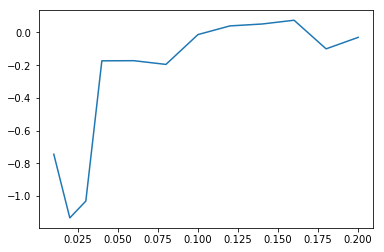

In [20]:
df_result['Excess Return'].plot()

In [21]:
s = df_result['Excess Return'].idxmax()
print (s)

0.16


In [22]:
df_result.to_clipboard()